# Reporte técnico: Modelos de riesgo de crédito

Integrantes

- Miguel Angel Bula Carmona

- Dioselin Esteban Brito Peñaloza

- Marcos David Carrillo Builes

- Yeferson Steven Aguilar Alvarado

## Introducción 
El incumplimiento de las obligaciones financieras por parte de los clientes es un temor y una molestia para la mayoría de los bancos, dado que este tipo de situaciones generan que se presente un activo improductivo (NPA) alto, conduciendo a que el banco presente enormes pérdidas financieras, lo que fácilmente se puede traducir en una reducción de la tasa de interés sobre el depósito. Estas situaciones han incentivado a los bancos a crear diferentes técnicas para diferenciar entre el cliente que cumplirá con sus obligaciones y el que no lo hará y de esta manera reducir la probabilidad de pérdida de la compañía proveniente de las dimensiones del valor de sus activos como consecuencia de que un deudor o contra parte incumpla con sus obligaciones.

La forma en que los bancos determinan el riesgo de crédito es evaluando a los clientes a través de sus activos fijos, el valor económico y la calidad de estos. De esta manera realizan un respectivo análisis en donde se evalúa la probabilidad de que el dinero otorgado sea devuelto considerando tanto aspectos cualitativos como cuantitativos.

El problema principal a tratar en este proyecto es identificar qué tan probable es que un cliente no cumpla con sus obligaciones financieras. Para el desarrollo del problema es importante tener presente que la variable default (incumplimiento de las obligaciones financieras) está dada en la columna loan_status del archivo adjunto. Se considera que un cliente incumple si está en default o si tiene un atraso en su pago (en Colombia es usual considerar el default como un atraso de 90 días para la mayoría de los productos de consumo). Lo importante es poder crear un modelo que permita estimar cuando una persona tiene alta probabilidad de incumplir con sus obligaciones financieras y así evitar que el banco presente enormes pérdidas a futuro.

El método a emplear para atacar esta problemática será el uso de regresión logística, que luego con los coeficientes entregados por este método se realiza el scorecard y la probabilidad de que un cliente incumpla con sus obligaciones (esta probabilidad tiene como base el scorecard).



## Metodología

Para el desarrollo o la construcción de un producto que encapsule una posible solución a la problemática descrita, se llevarán a cabo los siguientes pasos:

- Preparación de los datos: Eliminación de columnas con gran cantidad de valores nulos, selección de variables categóricas y continuas.

- Creación de agrupaciones para las variables continuas.

- Realización de weight of evidence e information value

- Creación de la regresión logística.

- Creación del scorecard.

## Desarrollo

### 1. Preparación de los datos

In [ ]:
# Primer paso: importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

Para la preparación primero debemos importar el Dataset: credit_risk_dataset.  Esta base contiene la información con la cual se procederá a realizar el trabajo. 

Figura 1. Visualización de los datos 

Dataset: credit_risk_dataset

In [ ]:
# Se importa el dataset
loanDataset = pd.read_csv('credit_risk_dataset.csv')
loanDataset.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Nota: La figura representa las primeras 5 filas del dataset. 

Para una representación correcta de la regresión es importante seleccionar una variable que cumpla la función de variable dependiente. La variable dependiente tomada es loan_status, ya que define si la deuda está en default (incumplimiento de las obligaciones) o no.

In [ ]:
# Se copia el dataset para no modificar sobre la original
loanDatasetCopy = loanDataset.copy()

Se procede a realizar la eliminación de las columnas en donde se presenta un porcentaje mayor al 60% en valores que contengan NA, para poder obtener un mejor análisis de los datos y que no haya lugar a resultados poco coherentes . 

In [ ]:
# Eliminar las columnas que tengan más del 60% de NA values
perc = 60.0 # Like N %
min_count =  int(((100-perc)/100)*loanDatasetCopy.shape[0] + 1)
loanDatasetCopy = loanDatasetCopy.dropna( axis=1, 
                thresh=min_count)

### Variables Continuas seleccionadas
*   loan_amnt: loan amount (Monto del préstamo)
*   person_age: Age (Edad)
*   loan_int_rate: Interest rate (Tasa de interés)
*   loan_percent_income: Percent income (Porcentaje de ingresos)
*   person_emp_length: Employment length (in years) (Duración del empleo (en años))
*   cb_person_cred_hist_length: Credit history length (Longitud del historial crediticio)

### Variables categóricas seleccionadas
* person_home_ownership: Home ownership (Propiedad de la vivienda)
* loan_intent: 	Loan intent (Intención de préstamo)
* loan_grade: Loan grade (Grado de préstamo)
* cb_person_default_on_file: Historical default (Incumplimiento histórico)

Nota: La explicación y asignación de los nombres de las variables anteriormente descritas se hace teniendo en cuenta el diccionario de datos alojado en https://www.kaggle.com/datasets/laotse/credit-risk-dataset

Luego de realizar los pasos anteriores en donde se agrupan las variables continuas y categóricas, además de retirar de la base de datos las variables que no aportan información de interes para el análisis, se procede a dividir el dataset en 4 grupos:

* X_train: Los datos de entrenamiento de las variables independientes.
* y_train: Los datos de entrenamiento de las variable dependiente.
* X_test: Los datos de prueba de las variables independientes.
* y_test: Los datos de prueba de la variable dependiente.



Los datos de entrenamiento van a representar el 70% del dataset, mientras que los de prueba el 30%.

In [ ]:
# Dividir las variables en X y Y (Split) Se va a realizar en proporción 70/30
X = list(loanDatasetCopy.columns.copy())
X.remove('loan_status')
X = loanDatasetCopy[X]
y = loanDatasetCopy['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state = 1, stratify = y)

A continuación procederemos a realizar el reinicio del index de las variables divididas.   

In [ ]:
# Se va a reiniciar el index de las variables divididas
# X_train
X_train = X_train.reset_index()
X_train = X_train.drop(['index'],axis=1)
# X_test
X_test = X_test.reset_index()
X_test = X_test.drop(['index'],axis=1)
# y_train
y_train = y_train.reset_index()
y_train = y_train.drop(['index'],axis=1)
y_train = y_train.values.flatten()
# y_test
y_test = y_test.reset_index()
y_test = y_test.drop(['index'],axis=1)
y_test = y_test.values.flatten()

Posteriormente se crean dos listas o arreglos que contienen las variables continuas y las variables categóricas respectivamente, pensando en el uso futuro de dichas estructuras.

In [ ]:
loanDatasetCopy.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
# Variables continuas
variablesContinuas = ['person_age', 
'person_income',
'person_emp_length',
'loan_amnt',
'loan_int_rate',
'loan_percent_income',
'cb_person_cred_hist_length']

In [ ]:
# Variables categóricas
variablesCategoricas = ['person_home_ownership',
'loan_intent',
'loan_grade',
'cb_person_default_on_file',

]

La matriz de correlación de la Figura 2 tiene como objetivo entender la correlación entre las distintas variables continuas que se tienen en cuenta hasta el momento.  Con ayuda de los datos que arroja esta matriz se puede determinar qué variables continuas se deben de eliminar. Dichas variables serán aquellas que presenten una alta correlación.

Figura 2

Matriz de correlación 

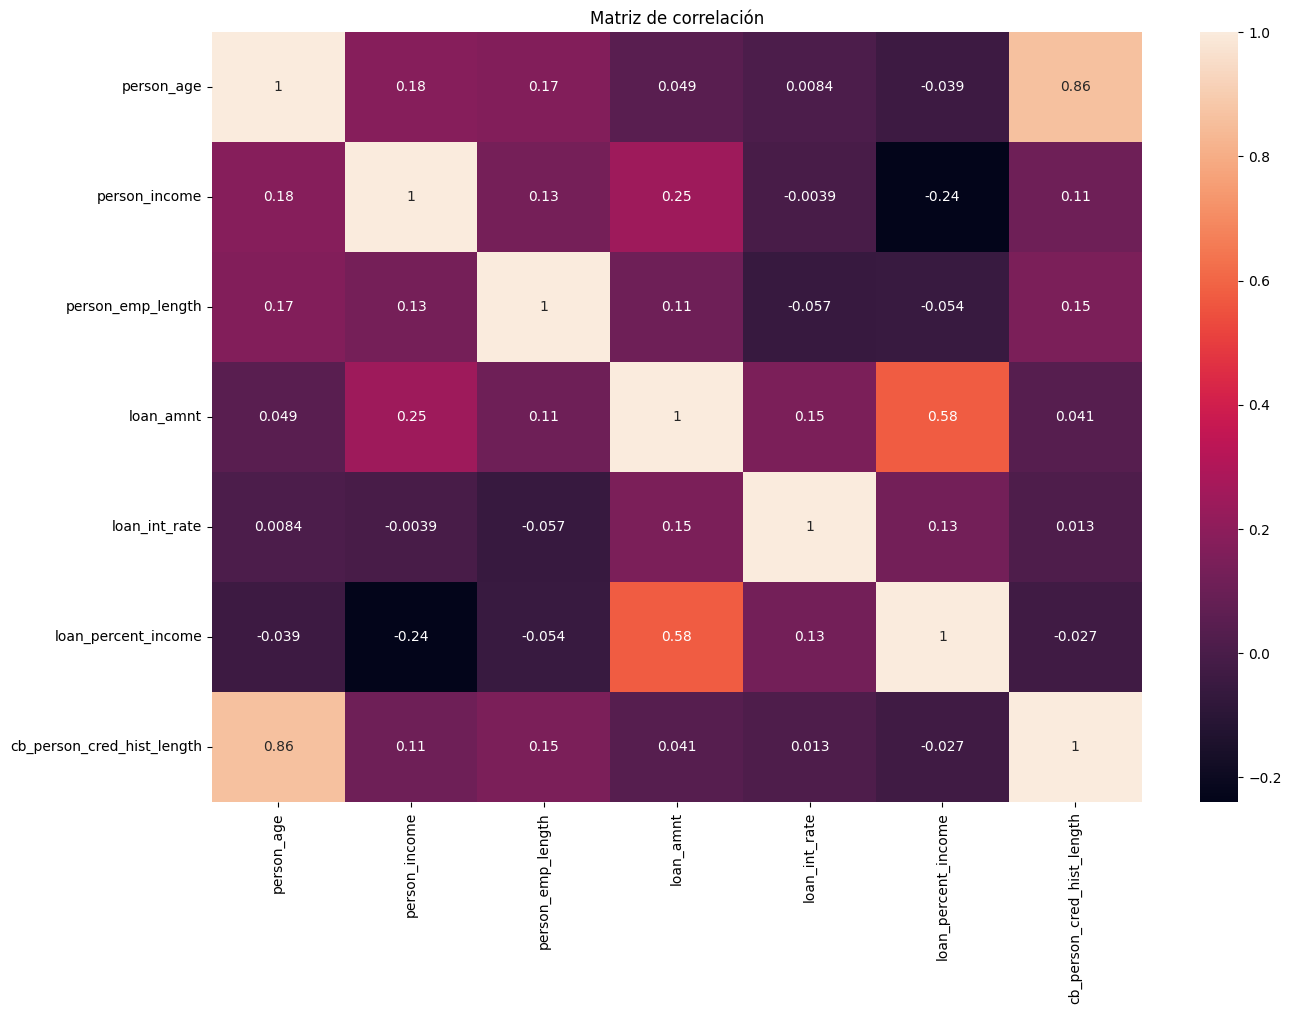

In [ ]:
# Vamos a identificar la correlación de  las variables continuas para ver qué variables se deben eliminar
corr_df = X_train[variablesContinuas].corr(method='pearson')

corr_df.index=variablesContinuas
corr_df.columns=variablesContinuas
plt.figure(figsize=(15, 10))
sns.heatmap(corr_df, annot=True)
plt.title("Matriz de correlación")
plt.show()

Nota: La matriz de correlación representa la correlación entre las variables seleccionadas.

Como se puede observar de la matriz de confusión, hay muy poca correlación entre las variables por lo tanto se tendrán en cuenta todas.

Para  realizar una buena selección de las variables categóricas es necesarios realizar la prueba de chi-cuadrado con un nivel de significancia para un $ \alpha$ = 0.05 y con una prueba de hipotesis:
$H_{0}$ = Las variables categoricas son dependentientes; esto quiere decir que $\alpha$ < valor_p.
$H_{1}$ = Las variables son independientes; esto quiere decir que $\alpha$ > valor_p.
Cada variable se registrará en una tabla contenida en la **Figura 3** con su respectivo valor p.

In [ ]:
# Selección de variables categóricas y continuas a utilizar
# Se utiliza el método de chi2
chi2_tabla = {'Variable':[],'Chi P-Value':[]}
for columna in variablesCategoricas:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train[columna]))
    chi2_tabla['Variable'].append(columna)
    chi2_tabla['Chi P-Value'].append(p)
chi2_tabla = pd.DataFrame(chi2_tabla)
chi2_tabla

,Variable,Chi P-Value
0,person_home_ownership,4.843303e-302
1,loan_intent,1.296627e-76
2,loan_grade,0.000000e+00
3,cb_person_default_on_file,2.285609e-170


Figura 3

Tabla de la prueba chi-cuadrado en variables categóricas

In [ ]:
chi2_tabla = chi2_tabla.sort_values(by=['Chi P-Value'])

In [ ]:
chi2_tabla

,Variable,Chi P-Value
2,loan_grade,0.000000e+00
0,person_home_ownership,4.843303e-302
3,cb_person_default_on_file,2.285609e-170
1,loan_intent,1.296627e-76


Nota: Esta tabla muestra todas las variables categóricas con su respectivo valor-p de la prueba chi-cuadrado.



De acuerdo al resultado anterior se puede observar que de las 4 variables categóricas, ninguna rechaza a $H_{0}$ dado que estas no presentan un valor_p > 0.05, por tanto no cumplen el papel de ser dependientes.


Ahora bien, cabe destacar que las variables de la tabla que se encuentra en la **Figura 3** rechazan la $H_{0}$ dado que estas presentan un valor_p < 0.05, lo que nos indica que estas variables son independientes.

Dicha segmentación y preferencia permitirá que el modelo sea más sencillo de comprender y manejar.

A continuación se procede a la verificación de las variables continuas que fueron seleccionadas con anterioridad. Además se procederá a realizar el reemplazo de los valores de los datos NaN con los valores de la mediana.

In [ ]:
# Ahora vamos a verificar qué variables continuas se van a seleccionar
# Primer paso: Copiar dataset que son de continuos
datasetContinuo = X_train[variablesContinuas].copy()
# Segundo paso, eliminar los na (se reemplazan con la mediana)
datasetContinuo = datasetContinuo.apply(lambda x: x.fillna(x.median()),axis=0)

Las variables continuas seleccionadas anteriormente se deben de verificar para conocer si realmente son funcionales o no para nuestro modelo. Se realiza esta verificación con la prueba con estadístico F. Esta prueba se ilustra en la Figura 4. 

### Variables Continuas seleccionadas para trabajar
*   loan_amnt
*   loan_int_rate
*   person_income
*   loan_percent_income
*   person_emp_length
*   cb_person_cred_hist_length
*   person_age

Para determinar si las variables que se decidieron no eliminar son aptas para ser empleadas en el modelo que se va a realizar, es necesario aplicar la prueba F de Fisher con un nivel de significancia $\alpha$ = 0.05, teniendo en cuenta las siguientes hipotesis:

$H_{0}$ = Las variables son dependientes por tanto una variable no varia en los distintos niveles de las demas varibales; con un valor_p > 0.05
$H_{1}$ = Las variables son independientes, una variable varia dentro de los niveles de las otras variables; con un valor_p < 0.05

Figura 4

Tabla de la prueba F de Fisher

In [ ]:
# Segundo paso: Calcular F statistic
# No se rechaza el H0, entonces se aceptan todas las variables
F_statistic, p_values = f_classif(datasetContinuo, y_train)
anovaTabla = pd.DataFrame(data = {'Feature':datasetContinuo.columns.values,'F-Score':F_statistic,'P-Value':p_values})
anovaTablaFeatureName= variablesContinuas
anovaTabla['Feature']=anovaTablaFeatureName
anovaTabla

,Feature,F-Score,P-Value
0,person_age,6.607957,1.015869e-02
1,person_income,437.821386,2.593369e-96
2,person_emp_length,163.002080,3.351289e-37
3,loan_amnt,279.307584,2.497764e-62
4,loan_int_rate,2683.514363,0.000000e+00
5,loan_percent_income,3845.863886,0.000000e+00
6,cb_person_cred_hist_length,2.908166,8.814564e-02


Nota: Esta tabla representa la prueba con estadístico F de las variables continuas a emplear en el modelo.

Hay evidencia suficiente para rechazar la $H_{0}$ en todas las variables ya que estas presentan un valor_p < 0.05, por tanto se pueden aceptar todas estas variables para la creación del modelo.

In [ ]:
# Ahora el dataset contendrá las variables categóricas y continuas seleccionadas anteriormente
variablesTotales = variablesCategoricas + variablesContinuas
X_train = X_train[variablesTotales]

In [ ]:
# Ahora se va agrupar por bins las variables continuas (de 10, dado que esa es la cantidad usual)
for variable in variablesContinuas:
    X_train[variable] = pd.cut(X_train[variable],10)

### Creación de agrupaciones para las variables continuas
Se procede a realizar la creacion de 10 agrupaciones por cada una de las variables continuas con las que se va a trabajar. Las agrupaciones se manejan con un rango de valores. Lo anterior puede verse con más claridad en la **Figura 5**  en las primeras 5 filas de X_train.

Figura 5

Tabla sobre la creación de agrupaciones para variables continuas

In [ ]:
# Mostrar la tabla de X_train
X_trainNames=list(chi2_tabla['Variable'])+anovaTablaFeatureName
X_trainC=X_train.copy()
X_trainC.columns=X_trainNames
X_trainC.head()

,loan_grade,person_home_ownership,cb_person_default_on_file,loan_intent,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,RENT,EDUCATION,A,N,"(19.876, 32.4]","(-1996.0, 603600.0]",NaN,"(465.5, 3950.0]","(5.403, 7.089]","(0.083, 0.166]","(1.972, 4.8]"
1,RENT,PERSONAL,B,N,"(19.876, 32.4]","(-1996.0, 603600.0]","(-0.123, 12.3]","(3950.0, 7400.0]",NaN,"(0.083, 0.166]","(1.972, 4.8]"
2,MORTGAGE,VENTURE,B,N,"(19.876, 32.4]","(-1996.0, 603600.0]","(-0.123, 12.3]","(7400.0, 10850.0]","(8.758, 10.427]","(0.083, 0.166]","(1.972, 4.8]"
3,MORTGAGE,VENTURE,D,N,"(32.4, 44.8]","(-1996.0, 603600.0]","(-0.123, 12.3]","(465.5, 3950.0]","(13.765, 15.434]","(-0.00083, 0.083]","(13.2, 16.0]"
4,RENT,MEDICAL,B,N,"(19.876, 32.4]","(-1996.0, 603600.0]","(-0.123, 12.3]","(3950.0, 7400.0]","(8.758, 10.427]","(0.166, 0.249]","(7.6, 10.4]"


Nota: Esta tabla muestra las 5 filas iniciales de X_train. Su objetivo es poder ilustrar las agrupaciones creadas de las variables continuas.

In [ ]:
# Crear un dataset para poder realizar WOE
woeData = X_train.copy()
woeData['y'] = list(y_train)

### Realización de Weight of Evidence e Information Value
Para realizar este proceso es necesario la creacion del Weight of Evidence e Information Value para cada variable.

Se eliminan algunas de estas variables seleccionadas anteriormente luego de realizar la prueba χ² y la prueba F debido a que en estas variables existen agrupaciones que no presentan algún caso de cumplimiento o incumplimiento financiero. También se eliminan debido a que el Information Value es menor a 0.02 o es mayor a 0.5.

In [ ]:
# Se va a realizar el WOE e Information Value (IV) para cada variable y para cada bin de cada variable
datasetsWoe = []
iV = []
# Las columnas que luego se usarán en el X_train, dado que para ello es el Woe tambien
columnasAgregar = []
for columna in X_train.columns:
    # Los bins de la columna
    valoresColumna = list(X_train[columna].unique())
    valoresColumna = [x for x in valoresColumna if str(x) != 'nan']
    # Las repeticiones de cada bin
    repeticiones = [X_train[columna].value_counts()[valor] for valor in valoresColumna]
    # La distribución de buenos y malos
    buenos = [len(woeData[(woeData[columna] == valor) & (woeData['y'] == 1)]) for valor in valoresColumna ]
    malos = [len(woeData[(woeData[columna] == valor) & (woeData['y'] == 0)]) for valor in valoresColumna ]
    distribucionBuena = [bueno/sum(buenos) for bueno in buenos]
    distribucionMala = [malo/sum(malos) for malo in malos]
    # La creación del dataset
    df= pd.DataFrame(data = {columna:valoresColumna,'Repeticiones':repeticiones,'Buenas':buenos,'Malas':malos,'Buena distribucion':distribucionBuena,'Mala distribucion':distribucionMala})
    df['WOE'] = np.log(df['Buena distribucion']/df['Mala distribucion'])
    ivColumna = sum((df['Buena distribucion'] - df['Mala distribucion']) * df['WOE'])
    # Se realiza este condicional para no agregar algún dato que tenga 0 en buenos o malos en algún bin.
    # Tambien se agregan los condiciones de ivColumna para no agregar variables que no funcionen para el calculo
    if math.isinf(ivColumna) == False and ivColumna > 0.02 and ivColumna < 0.5:
        datasetsWoe.append(df)
        iV.append(ivColumna)
        columnasAgregar.append(columna)
        print("Variable:",columna,"IV:",ivColumna)

    


Variable: person_home_ownership IV: 0.39563898593989705
Variable: loan_intent IV: 0.09578095855836759
Variable: cb_person_default_on_file IV: 0.17321552288093417
Variable: loan_amnt IV: 0.09153102390077517
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
columnasAgregar

['person_home_ownership',
 'loan_intent',
 'cb_person_default_on_file',
 'loan_amnt']

Las variables que van a ser utilizadas finalmente son:
* person_home_ownership
* loan_intent
* cb_person_default_on_file
* loan_amnt

In [ ]:
# Estas serán las columnas definidas para X_train
X_train = X_train[columnasAgregar]

In [ ]:
X_train.head()

,person_home_ownership,loan_intent,cb_person_default_on_file,loan_amnt
0,RENT,EDUCATION,N,"(465.5, 3950.0]"
1,RENT,PERSONAL,N,"(3950.0, 7400.0]"
2,MORTGAGE,VENTURE,N,"(7400.0, 10850.0]"
3,MORTGAGE,VENTURE,N,"(465.5, 3950.0]"
4,RENT,MEDICAL,N,"(3950.0, 7400.0]"


A continuación se realiza el procedimiento de preparación de los datos, con el objetivo de poder realizar la regresión logistica. Para esto es necesaria la creación de una columna por cada feature de cada columna de X_train. 

In [ ]:
# Ahora tenemos que preparar los datos para que se pueda realizar la regresión logistica.
# Se creará una columna por cada feature de cada columna de X_train
# El bloque de su creación se comentará, SI DESEA VER EL PROCEDIMIENTO DESCOMENTE LOS BLOQUES

X_trainRenovada = pd.DataFrame()
for columna in X_train.columns:
    for feature in X_train[columna].unique():
        nuevaColumna = str(columna) + ' ' + str(feature)
        X_trainRenovada[nuevaColumna] = []


In [ ]:
X_trainRenovada.head()

,person_home_ownership RENT,person_home_ownership MORTGAGE,person_home_ownership OWN,person_home_ownership OTHER,loan_intent EDUCATION,loan_intent PERSONAL,loan_intent VENTURE,loan_intent MEDICAL,loan_intent DEBTCONSOLIDATION,loan_intent HOMEIMPROVEMENT,...,"loan_amnt (465.5, 3950.0]","loan_amnt (3950.0, 7400.0]","loan_amnt (7400.0, 10850.0]","loan_amnt (14300.0, 17750.0]","loan_amnt (10850.0, 14300.0]","loan_amnt (24650.0, 28100.0]","loan_amnt (17750.0, 21200.0]","loan_amnt (31550.0, 35000.0]","loan_amnt (28100.0, 31550.0]","loan_amnt (21200.0, 24650.0]"


Posteriormente se realiza la transformación de los datos alojados en X_train

In [ ]:
# La transformación de los datos de X_train
# NOTA: DESCOMENTAR SI QUIERE ENTENDER EL PROCEDIMIENTO, ALTO TIEMPO DE EJECUCION

# listaTrainRenovadaColumna = list(X_trainRenovada.columns)
# for i in X_train.index:
#     datoRenovado = [0] * 22
#     for columna in X_train.columns:
#         nuevoString = str(columna) + ' ' + str(X_train.loc[i,columna])
#         if nuevoString in listaTrainRenovadaColumna:
#             datoRenovado[listaTrainRenovadaColumna.index(nuevoString)] = 1
#     X_trainRenovada.loc[i] = datoRenovado
#     print(i)




21807
21808
21809
21810
21811
21812
21813
21814
21815
21816
21817
21818
21819
21820
21821
21822
21823
21824
21825
21826
21827
21828
21829
21830
21831
21832
21833
21834
21835
21836
21837
21838
21839
21840
21841
21842
21843
21844
21845
21846
21847
21848
21849
21850
21851
21852
21853
21854
21855
21856
21857
21858
21859
21860
21861
21862
21863
21864
21865
21866
21867
21868
21869
21870
21871
21872
21873
21874
21875
21876
21877
21878
21879
21880
21881
21882
21883
21884
21885
21886
21887
21888
21889
21890
21891
21892
21893
21894
21895
21896
21897
21898
21899
21900
21901
21902
21903
21904
21905
21906
21907
21908
21909
21910
21911
21912
21913
21914
21915
21916
21917
21918
21919
21920
21921
21922
21923
21924
21925
21926
21927
21928
21929
21930
21931
21932
21933
21934
21935
21936
21937
21938
21939
21940
21941
21942
21943
21944
21945
21946
21947
21948
21949
21950
21951
21952
21953
21954
21955
21956
21957
21958
21959
21960
21961
21962
21963
21964
21965
21966
21967
21968
21969
21970
21971
21972
2197

In [ ]:
# NOTA: DESCOMENTAR SI QUIERE ENTENDER EL PROCEDIMIENTO, ALTO TIEMPO DE EJECUCION

# X_trainRenovada


,person_home_ownership RENT,person_home_ownership MORTGAGE,person_home_ownership OWN,person_home_ownership OTHER,loan_intent EDUCATION,loan_intent PERSONAL,loan_intent VENTURE,loan_intent MEDICAL,loan_intent DEBTCONSOLIDATION,loan_intent HOMEIMPROVEMENT,...,"loan_amnt (465.5, 3950.0]","loan_amnt (3950.0, 7400.0]","loan_amnt (7400.0, 10850.0]","loan_amnt (14300.0, 17750.0]","loan_amnt (10850.0, 14300.0]","loan_amnt (24650.0, 28100.0]","loan_amnt (17750.0, 21200.0]","loan_amnt (31550.0, 35000.0]","loan_amnt (28100.0, 31550.0]","loan_amnt (21200.0, 24650.0]"
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22801,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22802,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22803,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22804,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Luego se convierte la transformación anterior en un formato con extensión .csv, que tendrá por nombre X_train.csv

In [ ]:
# Se exporta el csv
# NOTA: DESCOMENTAR SI QUIERE ENTENDER EL PROCEDIMIENTO, ALTO TIEMPO DE EJECUCION

# X_trainRenovada.to_csv('X_train.csv')


In [ ]:
X_trainRenovada = pd.read_csv('X_train.csv')

In [ ]:
X_trainRenovada = X_trainRenovada.drop(['Unnamed: 0'],axis=1)

In [ ]:
X_trainRenovada.head()

,person_home_ownership RENT,person_home_ownership MORTGAGE,person_home_ownership OWN,person_home_ownership OTHER,loan_intent EDUCATION,loan_intent PERSONAL,loan_intent VENTURE,loan_intent MEDICAL,loan_intent DEBTCONSOLIDATION,loan_intent HOMEIMPROVEMENT,...,"loan_amnt (465.5, 3950.0]","loan_amnt (3950.0, 7400.0]","loan_amnt (7400.0, 10850.0]","loan_amnt (14300.0, 17750.0]","loan_amnt (10850.0, 14300.0]","loan_amnt (24650.0, 28100.0]","loan_amnt (17750.0, 21200.0]","loan_amnt (31550.0, 35000.0]","loan_amnt (28100.0, 31550.0]","loan_amnt (21200.0, 24650.0]"
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Se procede a realizar la transformación de X_train a X_test con el objetivo de poder comprobar la regresión logistica de forma correcta utilizando X_test.

Para esto es necesario, como primero, la selección de las columnas que se van a emplear en la regresión logistica. Despues se crea la nueva tabla X_test y finalmente se realiza la transformación de las filas, generando la transformación de X_test a x_testRenovada.

In [ ]:
# 1. Se seleccionan sólo las columnas que se van a emplear en la regresión logistica
X_test = X_test[columnasAgregar]
# 2. Creación de la nueva tabla de X_test
# Si quiere ver el procedimiento para la creación de X_testRenovada -> DESCOMENTE LOS BLOQUES

X_testRenovada = pd.DataFrame()
for columna in X_test.columns:
    for feature in X_train[columna].unique():
        nuevaColumna = str(columna) + ' ' + str(feature)
        X_testRenovada[nuevaColumna] = []



In [ ]:
X_testRenovada.columns

Index(['person_home_ownership RENT', 'person_home_ownership MORTGAGE',
       'person_home_ownership OWN', 'person_home_ownership OTHER',
       'loan_intent EDUCATION', 'loan_intent PERSONAL', 'loan_intent VENTURE',
       'loan_intent MEDICAL', 'loan_intent DEBTCONSOLIDATION',
       'loan_intent HOMEIMPROVEMENT', 'cb_person_default_on_file N',
       'cb_person_default_on_file Y', 'loan_amnt (465.5, 3950.0]',
       'loan_amnt (3950.0, 7400.0]', 'loan_amnt (7400.0, 10850.0]',
       'loan_amnt (14300.0, 17750.0]', 'loan_amnt (10850.0, 14300.0]',
       'loan_amnt (24650.0, 28100.0]', 'loan_amnt (17750.0, 21200.0]',
       'loan_amnt (31550.0, 35000.0]', 'loan_amnt (28100.0, 31550.0]',
       'loan_amnt (21200.0, 24650.0]'],
      dtype='object')

In [ ]:
# 3. Transformación de las filas de X_test a X_testRenovada
# NOTA: DESCOMENTAR SI QUIERE ENTENDER EL PROCEDIMIENTO, ALTO TIEMPO DE EJECUCION

# listaTestRenovadaColumna =list(X_testRenovada.columns)
# for i in X_test.index:
#     datoRenovado = [0] * 22
#     for columna in X_test.columns:
#         nuevoString = str(columna) + ' ' + str(X_test.loc[i,columna])
#         if nuevoString in listaTestRenovadaColumna:
#             datoRenovado[listaTestRenovadaColumna.index(nuevoString)] = 1
#     X_testRenovada.loc[i] = datoRenovado
#     print(i)


8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957
8958
8959
8960
8961
8962
8963
8964
8965
8966
8967
8968
8969
8970
8971
8972
8973
8974
8975


In [ ]:
# NOTA: DESCOMENTAR SI QUIERE ENTENDER EL PROCEDIMIENTO, ALTO TIEMPO DE EJECUCION

# X_testRenovada.to_csv('X_test.csv')


In [ ]:
X_testRenovada = pd.read_csv('X_test.csv')

In [ ]:
X_testRenovada = X_testRenovada.drop(['Unnamed: 0'],axis=1)

A continuación se procede a realizar la regresión logistica.


In [ ]:
regLog = LogisticRegression(max_iter=10000, class_weight = 'balanced',random_state=0).fit(X_trainRenovada, y_train)


Se procede a observar que tan exacta fue la regresión logística. Esta observación se realiza tanto para los datos de entrenamiento como para los datos de prueba.

In [ ]:
# Vamos a ver qué tan bien le fue al accuracy en nuestra regresión logistica
# 1. ¿Qué tan bien le fue a los datos de entrenamiento?
score = regLog.score(X_trainRenovada, y_train)
print("Accuracy en datos de entrenamiento:",score)
# 1.2. ¿Qué tan bien le fue a los datos de prueba?
score = regLog.score(X_testRenovada, y_test)
print("Accuracy en datos de prueba:",score)

Accuracy en datos de entrenamiento: 0.6661404893449092
Accuracy en datos de prueba: 0.5652173913043478


Como se puede observar, tanto para los datos de entrenamiento como para los datos de prueba, la regresión logística presenta aproximadamente un 66% de acierto en la clasificación, lo que puede indicar que dicha regresión acierta en más del 50% de las clasificaciones.

Ahora se analizan otras métricas importantes del modelo

In [ ]:
# Metricas de los datos
# 1. Datos de entrenamiento
predictions = regLog.predict(X_trainRenovada)
print(metrics.classification_report(y_train,predictions))

              precision    recall  f1-score   support

           0       0.89      0.65      0.75     17831
           1       0.36      0.71      0.48      4975

    accuracy                           0.67     22806
   macro avg       0.63      0.68      0.62     22806
weighted avg       0.77      0.67      0.69     22806



Para los datos de entrenamiento se tiene lo siguiente:

**Etiqueta 0 (Incumplimiento):** 

Precision: Un 89% de las personas propensas a incumplir realmente presentará incumplimiento 
Recall: Sólo se puede identificar a un 65% de los clientes que presentarán incumplimiento
F1 Score: Para esta clase se obtuvo un puntaje del 75%
Support: 17831 personas presentan incumplimiento

**Etiqueta 1 (No incumplimiento):**

Precision: Un 36% de las personas con tendencia a no incumplir realmente no tendrá algún imcumplimiento
Recall: Sólo se puede identificar a un 71% de los clientes que no presentarán incumplimiento
F1 Score: Para esta clase se obtuvo un puntaje del 48%
Support: 4975 personas no presentan incumplimiento

In [ ]:
# 2. Datos de prueba
predictions = regLog.predict(X_testRenovada)
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.90      0.50      0.64      7642
           1       0.31      0.79      0.44      2133

    accuracy                           0.57      9775
   macro avg       0.60      0.65      0.54      9775
weighted avg       0.77      0.57      0.60      9775



Para los datos de prueba se tiene lo siguiente:

**Etiqueta 0 (Incumplimiento):** 

Precisión: Un 90% de las personas propensas a incumplir realmente presentará incumplimiento 
Recall: Sólo se puede identificar a un 50% de los clientes que presentarán incumplimiento
F1 Score: Para esta clase se obtuvo un puntaje del 64%
Support: 7642 personas presentan incumplimiento

**Etiqueta 1 (No incumplimiento):**

Precisión: Un 31% de las personas con tendencia a no incumplir realmente no tendrá algún imcumplimiento
Recall: Sólo se puede identificar a un 79% de los clientes que no presentarán incumplimiento
F1 Score: Para esta clase se obtuvo un puntaje del 44%
Support: 2133 personas no presentan incumplimiento

Para la comprensión de la matriz de confusión para los datos de entrenamiento y de prueba, es importante entender qué son los valores que contiene esta matriz. Los valores en la diagonal principal ((1,1) y (2,2)) **(a = Verdaderos negativos)** y **(d = verdaderos positivos)** corresponden a los valores estimados de forma correcta por el modelo, y los valores de la diagonal secundaria ((2,1) y (1,2) **(c = falsos negativos)** y **(b = falsos positivos)** corresponden a los casos en los que el modelo se equivocó.

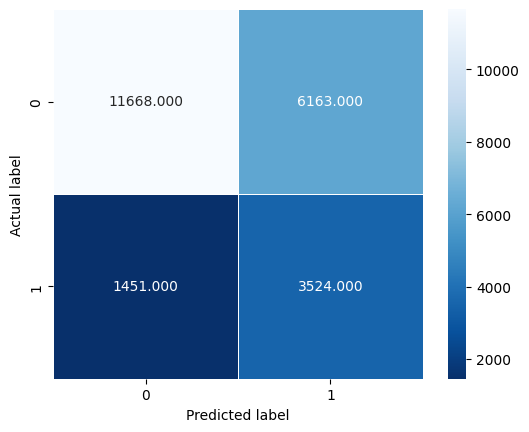

In [ ]:
# Ahora la matriz de confusión
# 1. Para los datos de entrenamiento
predictions = regLog.predict(X_trainRenovada)
cm = metrics.confusion_matrix(y_train, predictions)
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');


Dada la informacion anterior podemos ver que para los datos de entrenamiento el modelo acerto en a = 11668.000 y d = 3524.000 y no acerto en c = 1451.000 y b = 6163.000, lo que nos permite apreciar que es mayor el numero de valores estimados de forma correcta por el modelo.

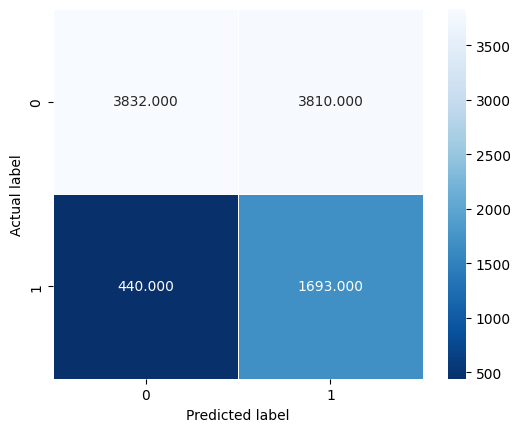

In [ ]:
# 1.2 Para los datos de prueba
predictions = regLog.predict(X_testRenovada)
cm = metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

Dada la informacion anterior podemos ver que para los datos de prueba el modelo acertó en a = 3832.000 y d = 1693.000 y no acertó en c = 440.000 y b = 3810.000, lo que nos permite apreciar que es mayor el número de valores estimados de forma correcta por el modelo.

A continuación se va a analizar la probabilidad de incumplimiento de un usuario (Valor representado con 0). Inicialmente se realiza este proceso para los datos de entrenamiento, como se observa en la **Figura 8**

In [ ]:
# Vamos a analizar la probabilidad de incumplimiento de un usuario (Este valor es representado con 0)
casoTrain = X_trainRenovada.copy()
casoTest = X_testRenovada.copy()
# Primero para los datos de entrenamiento
# Probabilidad de incumplimiento
probabilidadIncumplimiento = [round(elemento[0]*100,2) for elemento in regLog.predict_proba(X_trainRenovada)]
diccionarioCumplimiento = {0:"Incumplimiento",1:"Cumplimiento"}
RE = [diccionarioCumplimiento[elemento] for elemento in y_train]
RP = [diccionarioCumplimiento[elemento] for elemento in regLog.predict(X_trainRenovada)]
casoTrain["Probabilidad de incumplimiento"] = probabilidadIncumplimiento
casoTrain["Resultado Esperado"] = RE
casoTrain["Resultado predecido"] = RP


Como se puede apreciar en la **Figura 8** con los datos de entrenamiento de un total de 5 datos el modelo realizo un acierto en 4 de los 5 datos de entrenamiento entre los resultados esperados y los resultados predichos, otorgando un porcentaje de acierto del 80 % 

Figura 8 

In [ ]:
casoTrain.head()

,person_home_ownership RENT,person_home_ownership MORTGAGE,person_home_ownership OWN,person_home_ownership OTHER,loan_intent EDUCATION,loan_intent PERSONAL,loan_intent VENTURE,loan_intent MEDICAL,loan_intent DEBTCONSOLIDATION,loan_intent HOMEIMPROVEMENT,...,"loan_amnt (14300.0, 17750.0]","loan_amnt (10850.0, 14300.0]","loan_amnt (24650.0, 28100.0]","loan_amnt (17750.0, 21200.0]","loan_amnt (31550.0, 35000.0]","loan_amnt (28100.0, 31550.0]","loan_amnt (21200.0, 24650.0]",Probabilidad de incumplimiento,Resultado Esperado,Resultado predecido
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.07,Incumplimiento,Incumplimiento
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.45,Incumplimiento,Incumplimiento
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.50,Incumplimiento,Incumplimiento
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.71,Incumplimiento,Incumplimiento
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.20,Incumplimiento,Cumplimiento


A continuación se va a analizar la probabilidad de incumplimiento de un usuario (Valor representado con 0 ), para los datos de prueba, como se puede observar en la **Figura 9**

In [ ]:
# Ahora la probabilidad de incumplimiento para los datos de prueba
probabilidadIncumplimiento = [round(elemento[0]*100,2) for elemento in regLog.predict_proba(X_testRenovada)]
diccionarioCumplimiento = {0:"Incumplimiento",1:"Cumplimiento"}
RE = [diccionarioCumplimiento[elemento] for elemento in y_test]
RP = [diccionarioCumplimiento[elemento] for elemento in regLog.predict(X_testRenovada)]
casoTest["Probabilidad de incumplimiento"] = probabilidadIncumplimiento
casoTest["Resultado Esperado"] = RE
casoTest["Resultado predecido"] = RP

Figura 9

In [ ]:
casoTest

,person_home_ownership RENT,person_home_ownership MORTGAGE,person_home_ownership OWN,person_home_ownership OTHER,loan_intent EDUCATION,loan_intent PERSONAL,loan_intent VENTURE,loan_intent MEDICAL,loan_intent DEBTCONSOLIDATION,loan_intent HOMEIMPROVEMENT,...,"loan_amnt (14300.0, 17750.0]","loan_amnt (10850.0, 14300.0]","loan_amnt (24650.0, 28100.0]","loan_amnt (17750.0, 21200.0]","loan_amnt (31550.0, 35000.0]","loan_amnt (28100.0, 31550.0]","loan_amnt (21200.0, 24650.0]",Probabilidad de incumplimiento,Resultado Esperado,Resultado predecido
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.77,Cumplimiento,Incumplimiento
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.88,Cumplimiento,Cumplimiento
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.30,Incumplimiento,Incumplimiento
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.29,Incumplimiento,Cumplimiento
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.05,Cumplimiento,Cumplimiento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9770,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.51,Cumplimiento,Cumplimiento
9771,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.37,Cumplimiento,Incumplimiento
9772,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.64,Cumplimiento,Incumplimiento
9773,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.55,Cumplimiento,Incumplimiento


Aquí se realiza el cálculo del credit score. Para ello se deben definir los límites del Scorecard, y posteriormente crear la tabla de cada variable con su respectivo coeficiente

In [ ]:
# Calculo del credit score
# 1. Definir los limites del Scorecard
puntajeMinimo = 300
puntajeMaximo = 850
# 2. Crear la tabla de cada variable con su respectivo coeficiente
data = {"Variables":["Intercepto"]+list(X_trainRenovada.columns),"Coeficientes":[regLog.intercept_[0]]+list(regLog.coef_[0])}
scoreCardTabla = pd.DataFrame(data)

Figura 10

In [ ]:
scoreCardTabla

,Variables,Coeficientes
0,Intercepto,0.340734
1,person_home_ownership RENT,0.871924
2,person_home_ownership MORTGAGE,-0.452589
3,person_home_ownership OWN,-0.864195
4,person_home_ownership OTHER,0.450661
5,loan_intent EDUCATION,-0.322853
6,loan_intent PERSONAL,-0.117402
7,loan_intent VENTURE,-0.481106
8,loan_intent MEDICAL,0.254273
9,loan_intent DEBTCONSOLIDATION,0.340891


Ahora se obtendrá lo que representa cada variable para el aumento del score y así sacar la suma de todos los coeficientes mínimos y máximos de cada categoría.

In [ ]:
sumaMaximaCoeficientes = 0
sumaMinimaCoeficientes = 0
listaCoeficientes = []
for i in range(len(scoreCardTabla)):
    listaCoeficientes.append(scoreCardTabla.loc[i,"Coeficientes"])
    j = i+1
    if j > 22:
        j = 0
    if scoreCardTabla.loc[j,"Variables"][:3] != scoreCardTabla.loc[i,"Variables"][:3]:
        sumaMaximaCoeficientes += max(listaCoeficientes)
        sumaMinimaCoeficientes += min(listaCoeficientes)
        listaCoeficientes = []


In [ ]:
# Hora de calcular el score para cada variable
scoreCardTabla['Puntaje Crudo'] = scoreCardTabla['Coeficientes'] * (puntajeMaximo  - puntajeMinimo) / (sumaMaximaCoeficientes - sumaMinimaCoeficientes)
scoreCardTabla.loc[0, 'Puntaje Crudo'] = ((scoreCardTabla.loc[0,'Coeficientes'] - sumaMinimaCoeficientes) / (sumaMaximaCoeficientes - sumaMinimaCoeficientes)) * (550) + 300
# Se aproxima el puntaje para que este no quede en valores decimales
scoreCardTabla['Puntaje'] = scoreCardTabla['Puntaje Crudo'].round()

Figura 11

In [ ]:
# Realmente la suma se hará con el puntaje Crudo, el Puntaje será sólo como representación del aproximado
scoreCardTabla

,Variables,Coeficientes,Puntaje Crudo,Puntaje
0,Intercepto,0.340734,586.739027,587.0
1,person_home_ownership RENT,0.871924,98.488333,98.0
2,person_home_ownership MORTGAGE,-0.452589,-51.122332,-51.0
3,person_home_ownership OWN,-0.864195,-97.615329,-98.0
4,person_home_ownership OTHER,0.450661,50.904444,51.0
5,loan_intent EDUCATION,-0.322853,-36.467969,-36.0
6,loan_intent PERSONAL,-0.117402,-13.261210,-13.0
7,loan_intent VENTURE,-0.481106,-54.343371,-54.0
8,loan_intent MEDICAL,0.254273,28.721472,29.0
9,loan_intent DEBTCONSOLIDATION,0.340891,38.505378,39.0


A continuación se procede a encontrar las variables que hacen más riesgosa a una persona, por lo que se procederá a buscar las variables que presenten un porcentaje negativo. Esto será realizado con el scorecard.

Figura 12

In [ ]:
# Se debe de buscar las variables cuyo puntaje sea negativo, luego se ordena del menor al mayor
# 1. Elegir sólo las variables cuyo puntaje sea menor a 0
variablesRiesgosas = scoreCardTabla[(scoreCardTabla['Puntaje'] < 0)][["Variables","Puntaje"]]
# 2. Ordenar de menor a mayor
variablesRiesgosas.sort_values(by=['Puntaje'])
# 3. Exponer estas variables en el reporte técnico

,Variables,Puntaje
3,person_home_ownership OWN,-98.0
14,"loan_amnt (3950.0, 7400.0]",-79.0
15,"loan_amnt (7400.0, 10850.0]",-61.0
11,cb_person_default_on_file N,-56.0
7,loan_intent VENTURE,-54.0
13,"loan_amnt (465.5, 3950.0]",-54.0
2,person_home_ownership MORTGAGE,-51.0
17,"loan_amnt (10850.0, 14300.0]",-45.0
5,loan_intent EDUCATION,-36.0
6,loan_intent PERSONAL,-13.0


In [ ]:
# Veamos el puntaje maximo y minimo posible
sumaMaximaPuntaje= 0
sumaMinimaPuntaje = 0
listaPuntajes = []
for i in range(len(scoreCardTabla)):
    listaPuntajes.append(scoreCardTabla.loc[i,"Puntaje Crudo"])
    j = i+1
    if j > 22:
        j = 0
    if scoreCardTabla.loc[j,"Variables"][:3] != scoreCardTabla.loc[i,"Variables"][:3]:
        sumaMaximaPuntaje += max(listaPuntajes)
        sumaMinimaPuntaje += min(listaPuntajes)
        listaPuntajes = []

A continuación se procede a determinar, a partir del score si un usuario incumplirá o no con su crédito. Dado que la idea principal es utilizar los valores positivos, sólo se tendrán en cuenta dichos valores. Para este proceso se utilizarán los datos del test.

In [ ]:
# Ahora vamos a ver el score que define si el usuario va a incumplir su credito o no
# 1. Vamos a calcular el false positive rate y el true positive rate
# Como la idea es con los positivos entonces sólo se toman estos casos
# (Vamos a usar los datos del test en este caso)
y_test_proba = regLog.predict_proba(X_testRenovada)[:][: , 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_proba)

Figura 13

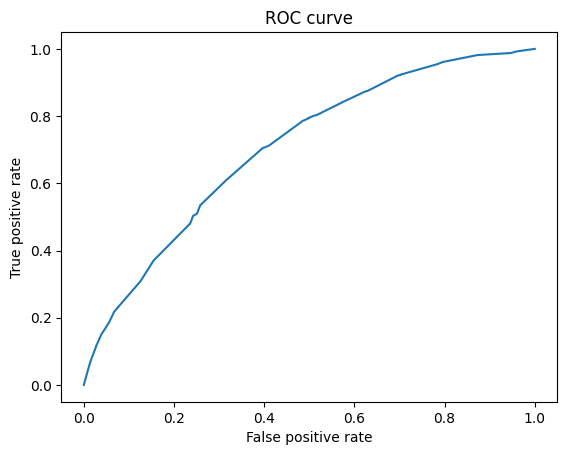

In [ ]:
# Vamos a imprimir un plot para visualizar esto de una mejor forma
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');


Aquí será importante encontrar el mejor threshold que maximice el true positive rate y que minimice el falso positive rate. 

In [ ]:
# La idea es encontrar un threshold que maximice el true positive rate y que minimice el false positive rate
J = tpr - fpr
# El mejor threshold
mejorThreshold = thresholds[np.argmax(J)]
print("El mejor threshold es:",round(mejorThreshold,5))

El mejor threshold es: 0.57826


Ahora lo que se hace es traducir este threshold al score limite (Se va a aproximar a techo, para evitar problemas de elegir personas que no cumplen con el limite). Como se aprecia a continuación el puntaje limite para definir si un cliente incumplirá o no es de 584. 

In [ ]:
scoreLimite = math.ceil(((math.log(mejorThreshold / (1 - mejorThreshold)) - sumaMinimaCoeficientes) * 
                       ((puntajeMaximo - puntajeMinimo) / (sumaMaximaCoeficientes - sumaMinimaCoeficientes)) + puntajeMinimo))
print("El puntaje limite para definir si un cliente incumplirá o no:",scoreLimite)

El puntaje limite para definir si un cliente incumplirá o no: 584


Obtenido el puntaje límite anterior, el cual permite saber si a un cliente se le deberá o no dar un crédito, se determina que se le negará el crédito a un cliente cuando éste presente un puntaje inferior a los 584.

In [ ]:
# ¿De qué sirve este puntaje? Para conocer si se le debería de dar un credito a un cliente o no

In [ ]:
puntaje = [round(sum(list(np.multiply([1]+list(casoTrain.loc[i,list(casoTrain.columns[:-3])]),list(scoreCardTabla['Puntaje Crudo']))))) for i in casoTrain.index]
casoTrain['Puntaje Crediticio'] = puntaje

In [ ]:
creditoAceptado = ["Si" if casoTrain.loc[i,"Puntaje Crediticio"] >= scoreLimite else "No" for i in casoTrain.index]
casoTrain["Aceptar Credito"] = creditoAceptado

In [ ]:
casoTrain.head()

,person_home_ownership RENT,person_home_ownership MORTGAGE,person_home_ownership OWN,person_home_ownership OTHER,loan_intent EDUCATION,loan_intent PERSONAL,loan_intent VENTURE,loan_intent MEDICAL,loan_intent DEBTCONSOLIDATION,loan_intent HOMEIMPROVEMENT,...,"loan_amnt (24650.0, 28100.0]","loan_amnt (17750.0, 21200.0]","loan_amnt (31550.0, 35000.0]","loan_amnt (28100.0, 31550.0]","loan_amnt (21200.0, 24650.0]",Probabilidad de incumplimiento,Resultado Esperado,Resultado predecido,Puntaje Crediticio,Aceptar Credito
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,52.07,Incumplimiento,Incumplimiento,539,No
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,52.45,Incumplimiento,Incumplimiento,537,No
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,83.50,Incumplimiento,Incumplimiento,365,No
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,82.71,Incumplimiento,Incumplimiento,371,No
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,43.20,Incumplimiento,Cumplimiento,579,No


In [ ]:
puntaje = [round(sum(list(np.multiply([1]+list(casoTest.loc[i,list(casoTest.columns[:-3])]),list(scoreCardTabla['Puntaje Crudo']))))) for i in casoTest.index]
casoTest['Puntaje Crediticio'] = puntaje

In [ ]:
creditoAceptado = ["Si" if casoTest.loc[i,"Puntaje Crediticio"] >= scoreLimite else "No" for i in casoTest.index]
casoTest["Aceptar Credito"] = creditoAceptado

In [ ]:
casoTest.head()

,person_home_ownership RENT,person_home_ownership MORTGAGE,person_home_ownership OWN,person_home_ownership OTHER,loan_intent EDUCATION,loan_intent PERSONAL,loan_intent VENTURE,loan_intent MEDICAL,loan_intent DEBTCONSOLIDATION,loan_intent HOMEIMPROVEMENT,...,"loan_amnt (24650.0, 28100.0]","loan_amnt (17750.0, 21200.0]","loan_amnt (31550.0, 35000.0]","loan_amnt (28100.0, 31550.0]","loan_amnt (21200.0, 24650.0]",Probabilidad de incumplimiento,Resultado Esperado,Resultado predecido,Puntaje Crediticio,Aceptar Credito
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,56.77,Cumplimiento,Incumplimiento,517,No
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,25.88,Cumplimiento,Cumplimiento,667,Si
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,67.30,Incumplimiento,Incumplimiento,467,No
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.29,Incumplimiento,Cumplimiento,770,Si
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,44.05,Cumplimiento,Cumplimiento,575,No


In [ ]:
scoreCardTabla

,Variables,Coeficientes,Puntaje Crudo,Puntaje
0,Intercepto,0.340734,586.739027,587.0
1,person_home_ownership RENT,0.871924,98.488333,98.0
2,person_home_ownership MORTGAGE,-0.452589,-51.122332,-51.0
3,person_home_ownership OWN,-0.864195,-97.615329,-98.0
4,person_home_ownership OTHER,0.450661,50.904444,51.0
5,loan_intent EDUCATION,-0.322853,-36.467969,-36.0
6,loan_intent PERSONAL,-0.117402,-13.261210,-13.0
7,loan_intent VENTURE,-0.481106,-54.343371,-54.0
8,loan_intent MEDICAL,0.254273,28.721472,29.0
9,loan_intent DEBTCONSOLIDATION,0.340891,38.505378,39.0


### Conclusiones

- Se pudo desarrollar un modelo, el cual permite al banco y al cliente, tener un puntaje para el cliente que desea obtener un crédito, con el fin de saber si es viable o no el desembolso del préstamo, donde puntajes inferiores a 584 determinan la  inviabilidad de dar el crédito, y donde puntajes mayores a ese valor determinan una alta probabilidad de cumplimiento para que el cliente pague a tiempo su crédito. 

- Por naturaleza del modelo, el banco podría perder clientes, y es probable que algunos sean catalogados como aquellos clientes morosos o que no presentan cumplimiento con sus responsabilidades financieras. No obstante, se puede tener más certeza de aquellos clientes en cuanto a su capacidad para cumplir con sus pendientes, lo que disminuye los riesgos para el banco que pueden darse en el momento de otorgar un crédito.

- En cuanto a la exactitud del modelo, se tiene un valor del 90% tanto en el entrenamiento como en la validación, podría ser suficiente dadas las necesidades del banco o la entidad, por lo que se puede garantizar una alta efectividad en el proceso, lo que brindaria un aumento significativo para las ganancias del banco.

### Referencia de donde se obtuvo información de apoyo.
* https://empresas.blogthinkbig.com/como-interpretar-la-matriz-de-confusion-ejemplo-practico/#:~:text=La%20matriz%20de%20confusi%C3%B3n%20es,con%20distintos%20tipos%20de%20error.
* https://www.listendata.com/2019/08/credit-risk-modelling.html
* http://www.rincondepaco.com.mx/rincon/Inicio/Apuntes/Proyecto/archivos/Documentos/Chi.pdf



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9bf70f57-8204-4e96-942e-40df61245296' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>